In [1]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
import numpy
# Our libs
from scene_seg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

In [17]:
from scene_seg.models import createDeepLabv3

file_path = './ckpt/deeplabv3_resnet101/model_epoch_5.pth'
model = createDeepLabv3(outputchannels=150)
model.load_state_dict(torch.load(file_path))
model.eval()
model.cuda()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [4]:
!wget -P ./ http://sceneparsing.csail.mit.edu/data/ADEChallengeData2016/images/validation/ADE_val_00001519.jpg

wget: /home/software/anaconda3/2019.10_powerai/lib/libuuid.so.1: no version information available (required by wget)
--2022-05-06 21:06:00--  http://sceneparsing.csail.mit.edu/data/ADEChallengeData2016/images/validation/ADE_val_00001519.jpg
Resolving sceneparsing.csail.mit.edu (sceneparsing.csail.mit.edu)... 128.30.195.26
Connecting to sceneparsing.csail.mit.edu (sceneparsing.csail.mit.edu)|128.30.195.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62271 (61K) [image/jpeg]
Saving to: ‘./ADE_val_00001519.jpg’

ADE_val_00001519.jp 100%[===================>]  60.81K  --.-KB/s    in 0.02s   

2022-05-06 21:06:01 (2.59 MB/s) - ‘./ADE_val_00001519.jpg’ saved [62271/62271]



In [12]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('ADE_val_00001519.jpg').convert('RGB')
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

In [13]:
def unique(ar, return_index=False, return_inverse=False, return_counts=False):
    ar = np.asanyarray(ar).flatten()

    optional_indices = return_index or return_inverse
    optional_returns = optional_indices or return_counts

    if ar.size == 0:
        if not optional_returns:
            ret = ar
        else:
            ret = (ar,)
            if return_index:
                ret += (np.empty(0, np.bool),)
            if return_inverse:
                ret += (np.empty(0, np.bool),)
            if return_counts:
                ret += (np.empty(0, np.intp),)
        return ret
    if optional_indices:
        perm = ar.argsort(kind='mergesort' if return_index else 'quicksort')
        aux = ar[perm]
    else:
        ar.sort()
        aux = ar
    flag = np.concatenate(([True], aux[1:] != aux[:-1]))

    if not optional_returns:
        ret = aux[flag]
    else:
        ret = (aux[flag],)
        if return_index:
            ret += (perm[flag],)
        if return_inverse:
            iflag = np.cumsum(flag) - 1
            inv_idx = np.empty(ar.shape, dtype=np.intp)
            inv_idx[perm] = iflag
            ret += (inv_idx,)
        if return_counts:
            idx = np.concatenate(np.nonzero(flag) + ([ar.size],))
            ret += (np.diff(idx),)
    return ret

def colorEncode(labelmap, colors, mode='RGB'):
    labelmap = labelmap.astype('int')
    labelmap_rgb = np.zeros((labelmap.shape[0], labelmap.shape[1], 3),
                            dtype=np.uint8)
    for label in unique(labelmap):
        if label < 0:
            continue
        labelmap_rgb += (labelmap == label)[:, :, np.newaxis] * \
            np.tile(colors[label],
                    (labelmap.shape[0], labelmap.shape[1], 1))

    if mode == 'BGR':
        return labelmap_rgb[:, :, ::-1]
    else:
        return labelmap_rgb

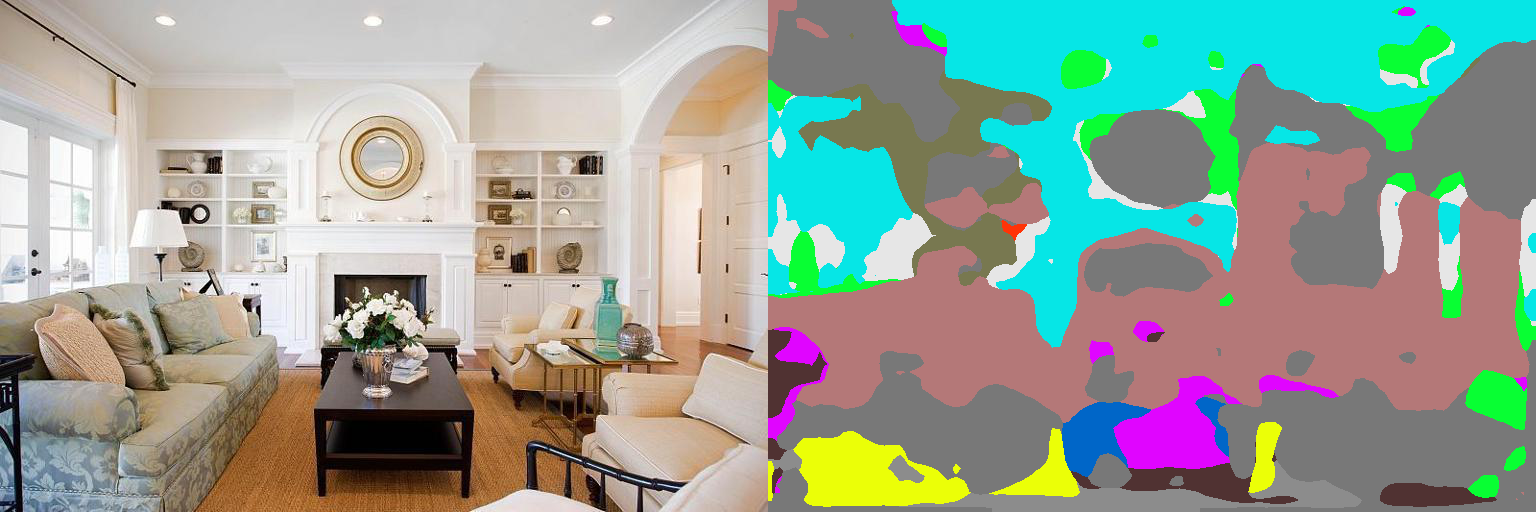

In [46]:
# Run the segmentation at the highest resolution.
import numpy as np
with torch.no_grad():
    scores = model(singleton_batch['img_data'])['out']
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

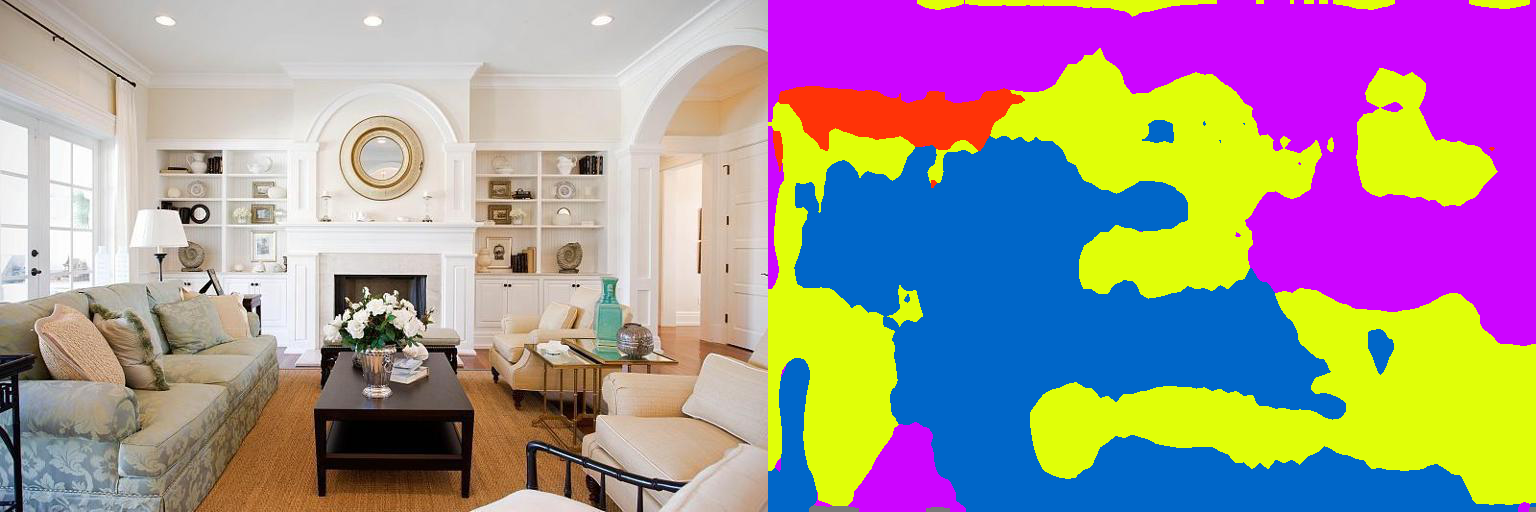

In [7]:
# Run the segmentation at the highest resolution.
import numpy as np
with torch.no_grad():
    scores = model(singleton_batch['img_data'])['out']
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

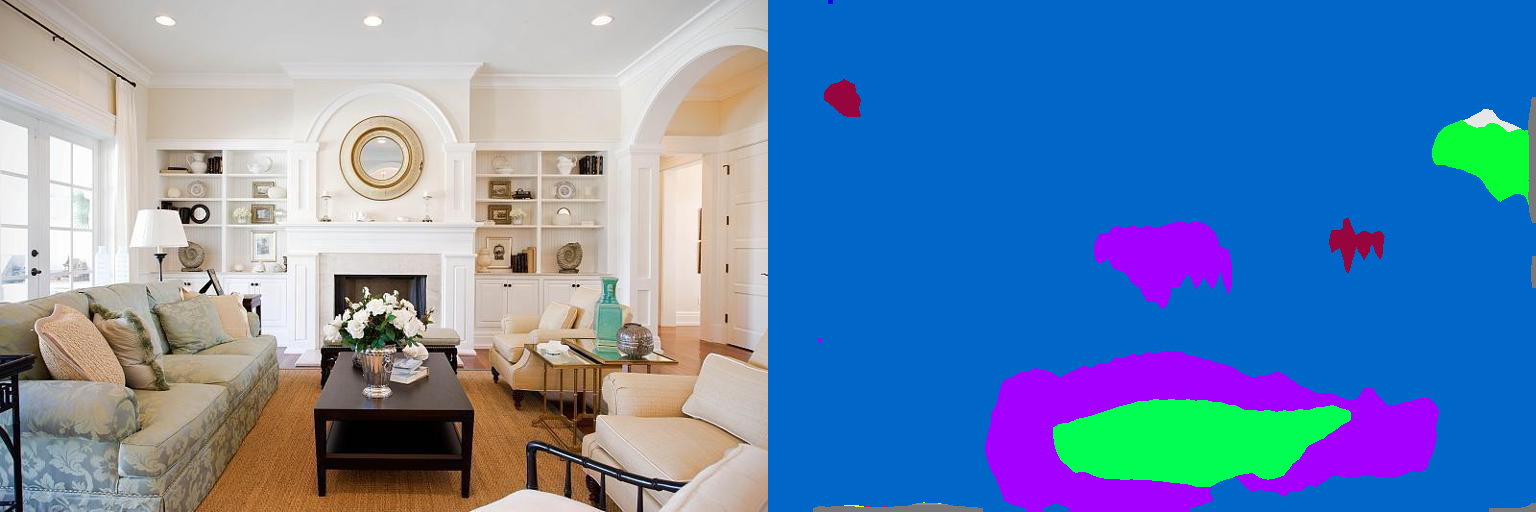

In [14]:
# Run the segmentation at the highest resolution.
import numpy as np
with torch.no_grad():
    scores = model(singleton_batch['img_data'])['out']
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

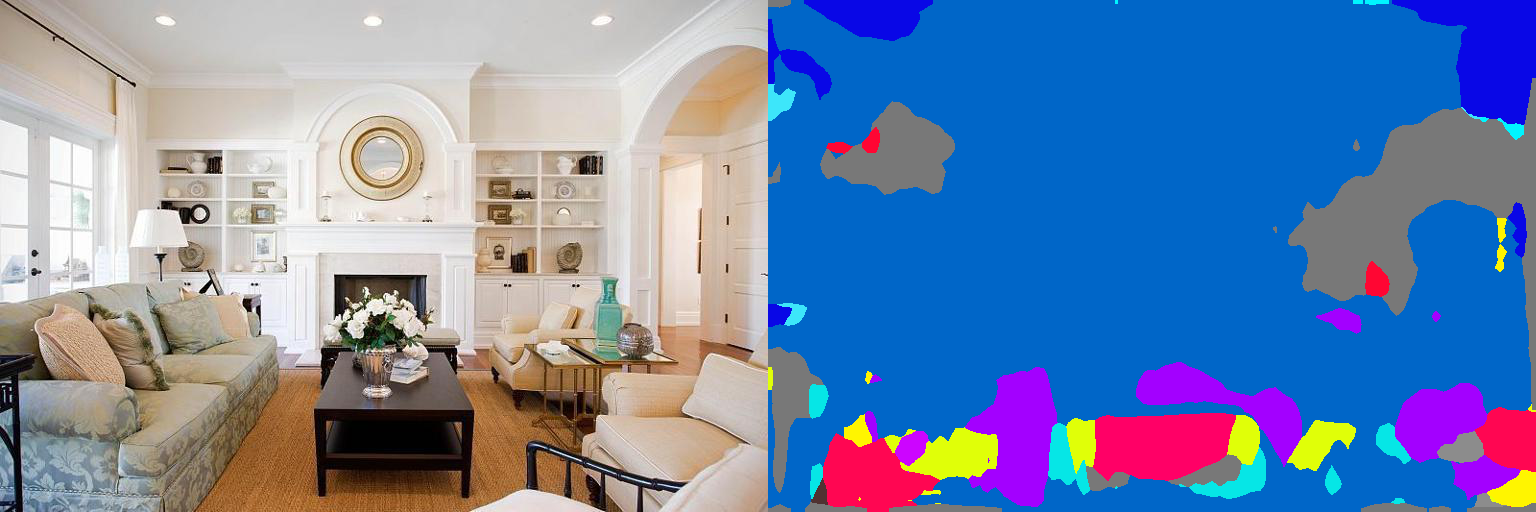

In [18]:
# Run the segmentation at the highest resolution.
import numpy as np
with torch.no_grad():
    scores = model(singleton_batch['img_data'])['out']
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)